In [1]:
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install phik -q
!pip install scikit-learn==1.2.2 imbalanced-learn==0.11.0 -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     GridSearchCV, cross_val_score, TimeSeriesSplit)

from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error,
                             accuracy_score, roc_auc_score, confusion_matrix,
                             recall_score, precision_score, make_scorer)

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import (SelectKBest, mutual_info_regression,
                                       mutual_info_classif)

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


RANDOM_STATE = 42

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-подготовка" data-toc-modified-id="Загрузка-данных-и-подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Создание-новый-признаков" data-toc-modified-id="Создание-новый-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание новый признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-пайплайна" data-toc-modified-id="Создание-пайплайна-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание пайплайна</a></span></li><li><span><a href="#Обучение-моеделй" data-toc-modified-id="Обучение-моеделй-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моеделй</a></span></li><li><span><a href="#Обучение-модели-LightGBM" data-toc-modified-id="Обучение-модели-LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Обучение модели LightGBM</a></span></li><li><span><a href="#Обучение-модели-CatBoost" data-toc-modified-id="Обучение-модели-CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Обучение модели CatBoost</a></span></li><li><span><a href="#Подбор-гиперпараметров-для-небустинговых-моделей" data-toc-modified-id="Подбор-гиперпараметров-для-небустинговых-моделей-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Подбор гиперпараметров для небустинговых моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Анализ-остатков" data-toc-modified-id="Анализ-остатков-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Анализ остатков</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Этапы работы**

**1. Загрузка и подготовка данных**  
- Получение данных из файла `/datasets/taxi.csv`.  
- Ознакомление со структурой данных.  
- Преобразование формата данных и ресемплирование по одному часу.  

**2. Анализ данных**  
- Исследование распределения количества заказов.  
- Выявление трендов и сезонности.  
- Поиск выбросов и аномалий.  

**3. Создание признаков**  
- Добавление временных признаков (день недели, час, месяц и др.).  
- Разработка лаговых признаков.  
- Создание скользящих средних.  

**4. Разделение данных**  
- Разделение на обучающую и тестовую выборки (10% от исходных данных).   

**5. Обучение и оценка моделей**  
- Тестирование различных моделей машинного обучения (линейные модели, градиентный бустинг, случайный лес и др.).  
- Настройка гиперпараметров для улучшения качества модели.  
- Оценка качества моделей с использованием кросс-валидации.  

**6. Проверка модели на тестовой выборке**  
- Прогнозирование количества заказов на тестовых данных.  
- Расчёт RMSE и сравнение с целевым значением (≤ 48).  
- Анализ ошибок модели.   

## Загрузка данных и подготовка

In [3]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [4]:
def data_info(dataset):
    print("Первые строки датафрейма")
    display(dataset.head())
    print('\n\nПервичная информация')
    dataset.info()
    print('-' * 50)
    print('\n\n')

In [5]:
data_info(data)

Первые строки датафрейма


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32




Первичная информация
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
--------------------------------------------------





In [6]:
# Проверим за какой промежуток времени собраны данные
print(f"Данные собраны с {data.index.min().strftime('%Y-%m-%d')} по {data.index.max().strftime('%Y-%m-%d')}")

Данные собраны с 2018-03-01 по 2018-08-31


In [7]:
# Выполним ресемпирование по одному часу
data = data.resample('1H').sum()
data_info(data)

Первые строки датафрейма


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43




Первичная информация
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
--------------------------------------------------





In [8]:
#Проверка, что индекс монотонный
print(data.index.is_monotonic)

True


В данных нет пропусков

Столбец с датами приведем к формату datetime

Проведено ресемплирование по одному часу

Даты расположены по возрастанию

Данные собраны с 2018-03-01 по 2018-08-31

## Анализ

Сначала посмотрим на график количества заказов

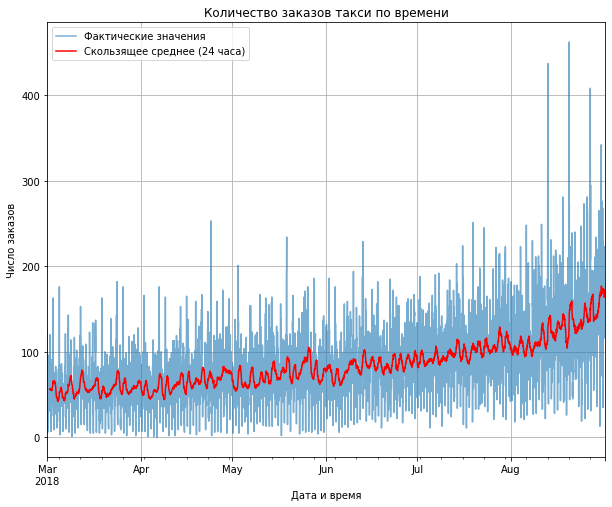

In [9]:
# Сначала посмотрим на график количества заказов
plt.figure(figsize=(10, 8))
data['num_orders'].plot(label='Фактические значения', alpha=0.6)

# Скользящее среднее с окном 24 часа
data['num_orders'].rolling(24).mean().plot(label='Скользящее среднее (24 часа)', color='red')

plt.title("Количество заказов такси по времени")
plt.xlabel("Дата и время")
plt.ylabel("Число заказов")
plt.legend()
plt.grid(True)
plt.show()

Заметим, что среднее количество заказов в день постепенно увеличивается к лету, что может быть связано с тем, компания растет, увеличивается база лояльных клиентов, которые готовы повторно обращаться за услугой

In [10]:
# Создаем столбец с месяцами днями и часами и определяем сезоны
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
#Создадим признак с днем недели
data['day_of_week'] = data.index.dayofweek

Разделим данные на тренды и сезонность и посмотрим на всех данных, на данных по кадому времени года, а так же по каждому месяцу

In [11]:
data.head()

,num_orders,month,day,hour,day_of_week
datetime,,,,,
2018-03-01 00:00:00,124,3,1,0,3
2018-03-01 01:00:00,85,3,1,1,3
2018-03-01 02:00:00,71,3,1,2,3
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,4,3


In [12]:
# Разделяем на тренд и сезонную компоненту
decomposed = seasonal_decompose(data['num_orders'])

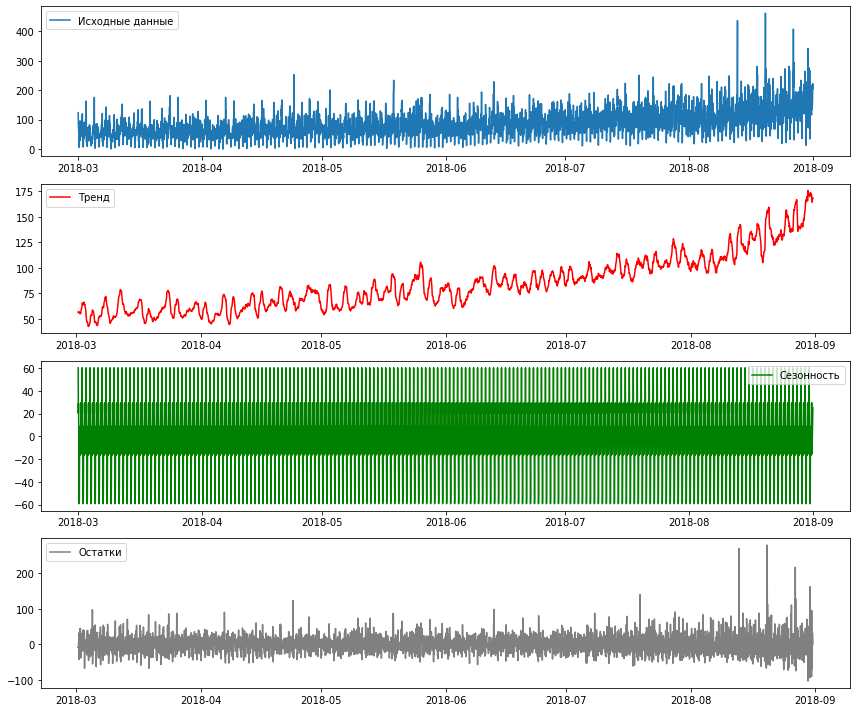

In [13]:
# Строим графики
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(data['num_orders'], label="Исходные данные")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposed.trend, label="Тренд", color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposed.seasonal, label="Сезонность", color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposed.resid, label="Остатки", color='gray')
plt.legend()

plt.tight_layout()
plt.show()

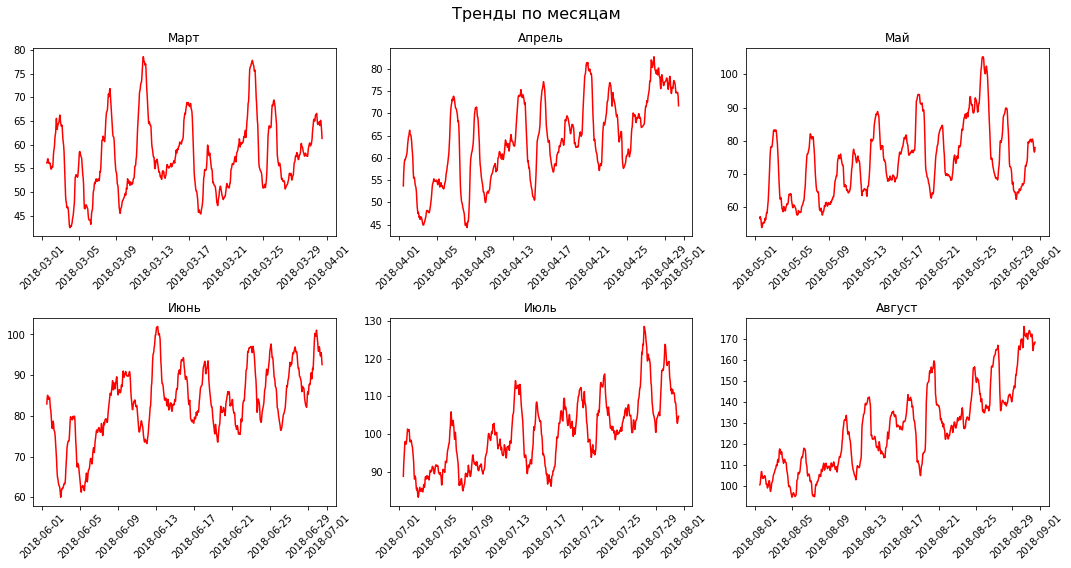

In [14]:
# Тренды и сезонность по месяцам

# Сезонность по месяцам не дает никаких нагладных выводов поэтому уберем ее из вывода

months = ['Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Тренды по месяцам", fontsize=16)
for i, month in enumerate(sorted(data['month'].unique())):
    season_data = data[data['month'] == month]['num_orders']
    decomposed = seasonal_decompose(season_data)
    
    row, col = divmod(i, 3)

    axes[row, col].plot(decomposed.trend, label="Тренд", color='red')
    axes[row, col].set_title(f"{months[month - 3]}")
    axes[row, col].tick_params(axis='x', rotation=45)  # Наклон подписей оси X

plt.tight_layout() 
plt.show()

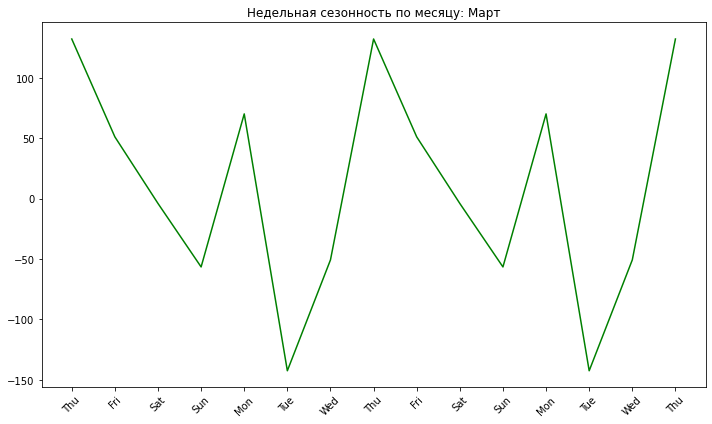

In [15]:
# Посмотрим на первые 2 недели марта, чтобы посмотреть не недельную сезонность
march_data = data[data.month == 3].resample('1D').sum()['num_orders']
decomposed = seasonal_decompose(march_data)
plt.figure(figsize=(10, 6))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-15'], color='green')
plt.title(f"Недельная сезонность по месяцу: {months[0]}")
seasonality = decomposed.seasonal.loc['2018-03-01':'2018-03-15']
plt.xticks(seasonality.index, seasonality.index.strftime('%a'), rotation=45)
plt.tight_layout()
plt.show()


1. -----------------------

График демонстрирует четкую недельную сезонность спроса на такси. В четверг и пятницу наблюдается рост количества заказов, что может быть связано с увеличением числа деловых поездок и началомпутешествий. Воскресенье и понедельник также выделяются повышенным спросом, так как многие возвращаются из поездок, а бизнес-путешественники начинают рабочую неделю. Напротив, во вторник заказы снижаются, что объясняется отсутствием значительных перелетов в этот день

2. ---------------

Рост спроса с марта по август

В марте и апреле среднее количество заказов находится в диапазоне 45–80.

В июне и июле спрос повышается (60–130).

В августе наблюдается максимальный уровень заказов — до 170 в день

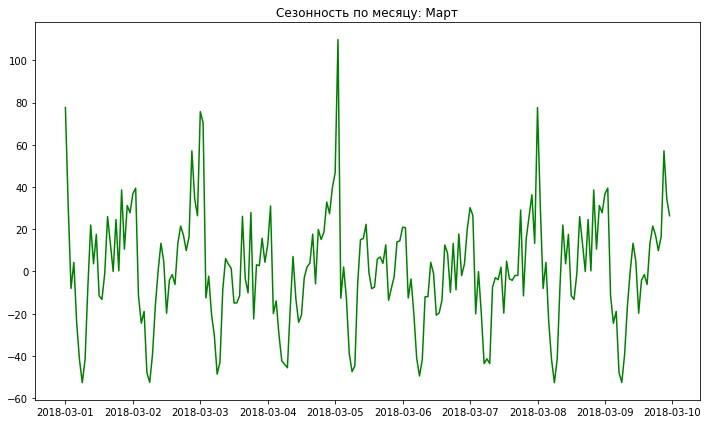

In [16]:
# Посмотрим на первые 8 дней марта
march_data = data[data.month == 3]['num_orders']
decomposed = seasonal_decompose(march_data, period = 168)
plt.figure(figsize=(10, 6))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-09'], color='green')
plt.title(f"Сезонность по месяцу: {months[0]}")
plt.tight_layout()
plt.show()


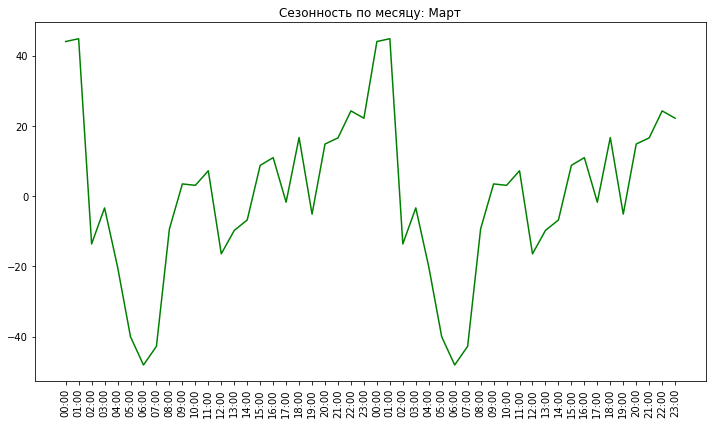

In [17]:
# Посмотрим на первые 2 дня марта по часам
march_data = data[data.month == 3]['num_orders']
decomposed = seasonal_decompose(march_data)
plt.figure(figsize=(10, 6))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-02'], color='green')
plt.title(f"Сезонность по месяцу: {months[0]}")
# Детализированные метки оси X (по часам)
plt.xticks(decomposed.seasonal['2018-03-01':'2018-03-02'].index, 
           [t.strftime('%H:%M') for t in decomposed.seasonal['2018-03-01':'2018-03-02'].index], 
           rotation=90)  # Поворот меток для лучшего восприятия

plt.tight_layout()
plt.show()

* Ночью, особенно после полуночи, количество заказов резко падает, так как в это время минимальное число прилетов и вылетов. Около 5-6 утра наблюдается минимум. Затем с 7-8 утра спрос начинает активно расти, отражая прибытие утренних рейсов

* В течение дня спрос остается относительно стабильным, с колебаниями, которые могут быть связаны с регулярными волнами прилетов и отлетов. Вечером, особенно ближе к 22-23 часам, фиксируется заметный пик, который может быть вызван завершением рабочих поездок и прибытием вечерних рейсов

In [18]:
data.head()

,num_orders,month,day,hour,day_of_week
datetime,,,,,
2018-03-01 00:00:00,124,3,1,0,3
2018-03-01 01:00:00,85,3,1,1,3
2018-03-01 02:00:00,71,3,1,2,3
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,4,3


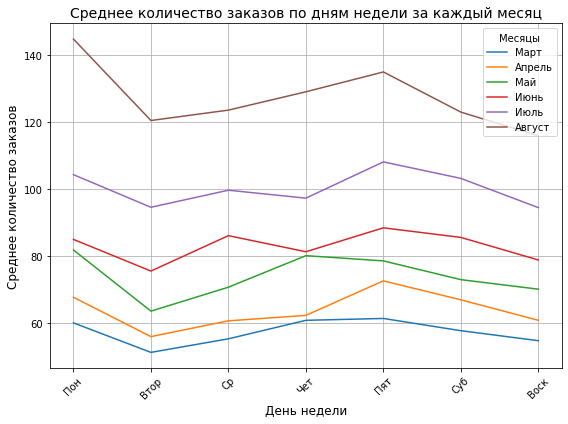

In [19]:
#Среднее количество заказов такси за каждый месяц по дням недели
mean_week = data.groupby(['day_of_week', 'month'])['num_orders'].mean().reset_index()
pivot = mean_week .pivot_table(index='day_of_week', columns='month', values='num_orders')

plt.figure(figsize=(8, 6))

for month in pivot.columns:
    plt.plot(pivot.index, pivot[month], label=f'Месяц {month}')
    
plt.title('Среднее количество заказов по дням недели за каждый месяц', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)
plt.xticks(ticks=range(7), labels=['Пон', 'Втор', 'Ср', 'Чет', 'Пят', 'Суб', 'Воск'], rotation=45)
plt.legend(months, title='Месяцы')
plt.grid(True)
plt.tight_layout()
plt.show()

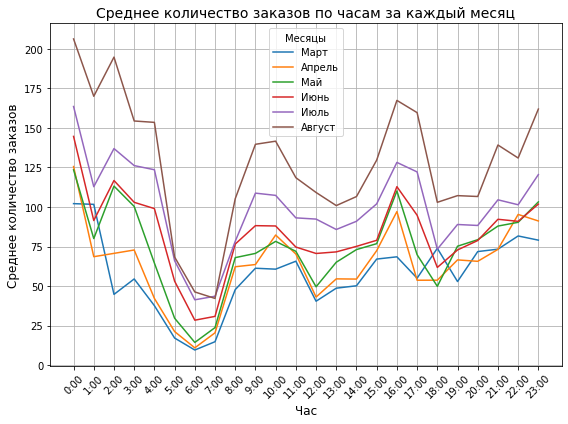

In [20]:
# Среднее количество заказов такси за каждый месяц по часам
mean_hour = data.groupby(['hour', 'month'])['num_orders'].mean().reset_index()
pivot = mean_hour.pivot_table(index='hour', columns='month', values='num_orders')


plt.figure(figsize=(8, 6))


for month in pivot.columns:
    plt.plot(pivot.index, pivot[month], label=f'Месяц {month}')


plt.title('Среднее количество заказов по часам за каждый месяц', fontsize=14)
plt.xlabel('Час', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)
plt.xticks(ticks=range(24), labels=[f'{i}:00' for i in range(24)], rotation=45)
plt.legend(months, title='Месяцы')
plt.grid(True)
plt.tight_layout()
plt.show()

### Вывод

* В течение года спрос растёт с марта по август, достигая пика (до 170 заказов в день) в августе.
* Недельная сезонность: Пики заказов в четверг, пятницу, воскресенье и понедельник; минимум во вторник.
* Суточная сезонность: Минимум заказов после полуночи, рост с 7-8 утра, пик в 22-23 часа.

## Создание новый признаков

In [21]:
# Добавим лаги до 24, чтобы смоделироват суточную сезонность, а так же добавим лаг 24*7
for lag in range(1, 24):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['lag_168'] = data['num_orders'].shift(168)
# Аналогично добавим скользящее среднее с окнами 6, 8, 12, 24 и 24*7
data['rolling_mean_6'] = data['num_orders'].shift(1).rolling(6).mean()
data['rolling_mean_8'] = data['num_orders'].shift(1).rolling(8).mean()
data['rolling_mean_12'] = data['num_orders'].shift(1).rolling(12).mean()
data['rolling_mean_24'] = data['num_orders'].shift(1).rolling(24).mean()
data['rolling_mean_168'] = data['num_orders'].shift(1).rolling(168).mean()

## Обучение

Разделим датасет на тренировочную и тестовую выборки

In [22]:
data.head()

,num_orders,month,day,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_168,rolling_mean_6,rolling_mean_8,rolling_mean_12,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns='num_orders')  # Признаки
y_train = train['num_orders']  # Целевая переменная
X_test = test.drop(columns='num_orders')  # Признаки
y_test = test['num_orders']  # Целевая переменная

In [24]:
data.head()

,num_orders,month,day,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_168,rolling_mean_6,rolling_mean_8,rolling_mean_12,rolling_mean_24,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Создание пайплайна

In [25]:
ohe_columns = ['month', 'day', 'hour', 'day_of_week']
num_columns = [f'lag_{i}' for i in range(1, 24)] + ['lag_168', 'rolling_mean_6', 'rolling_mean_8', 'rolling_mean_12', 'rolling_mean_24', 'rolling_mean_168']

In [26]:
# создаём пайплайн для подготовки признаков из списка ohe_columns OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)),
     ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаём пайплайн для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', MinMaxScaler())
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# Создаём итоговый пайплайн для Линейной регрессии
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),  
    ('model', LinearRegression())
])

### Обучение моеделй

In [27]:
param_grid = {
    'model': [
        DecisionTreeRegressor(random_state=RANDOM_STATE),
        LinearRegression(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(random_state=RANDOM_STATE)
    ]
}
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
%%time
gridCV = GridSearchCV(
    pipe_final, 
    param_grid = param_grid, 
    cv=tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
)

CPU times: user 20 µs, sys: 4 µs, total: 24 µs
Wall time: 26.7 µs


In [29]:
%%time
gridCV.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories

CPU times: user 29.5 s, sys: 2.84 s, total: 32.3 s
Wall time: 32.6 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('...
                                                                          'lag_20',
                                                                          'lag_21',
                                                                          'lag_22',
                                                                          'lag_23',
                                                                          'lag_168',
                                                                          'rolling_mean_6',
                                                                          'rolling_mean_8',
                                                                          'rolling_mean_12',
                                                                          'rolling_mean_24',
                                                                          'rolling_mean_168'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeRegressor(random_state=42),
                                   LinearRegression(), Ridge(), Lasso(),
                                   RandomForestRegressor(random_state=42)]},
             scoring='neg_root_mean_squared_error')

In [30]:
# Выводим полную таблицу результатов
results_df = pd.DataFrame(gridCV.cv_results_)
results_df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,3.704272,1.717963,0.022373,0.000925,RandomForestRegressor(random_state=42),{'model': RandomForestRegressor(random_state=42)},-2.085902e+01,-21.822406,-22.652323,-22.604749,-29.097736,-2.340725e+01,2.918930e+00,1
2,0.279197,0.059912,0.156759,0.040804,Ridge(),{'model': Ridge()},-2.448338e+01,-22.702852,-21.893786,-25.991386,-33.252657,-2.566481e+01,4.051461e+00,2
3,0.169305,0.049622,0.151968,0.043963,Lasso(),{'model': Lasso()},-2.216031e+01,-25.920182,-24.149955,-26.618537,-33.999345,-2.656967e+01,4.022978e+00,3
0,0.094223,0.036876,0.008880,0.000319,DecisionTreeRegressor(random_state=42),{'model': DecisionTreeRegressor(random_state=42)},-2.793619e+01,-31.314624,-33.739749,-32.531591,-40.323632,-3.316916e+01,4.067968e+00,4
1,0.258723,0.050410,0.113778,0.044737,LinearRegression(),{'model': LinearRegression()},-9.641896e+14,-23.083673,-22.496960,-28.749024,-38.202712,-1.928379e+14,3.856758e+14,5


Две модели RandomForestRegressor(random_state=42) и Ridge()	показали очень близкие результаты 22.4 и 22.5 соответственно, но RandomForestRegressor(random_state=42) обучается значительно дольше поэтому выберем Ridge()

### Обучение модели LightGBM

In [31]:
for col in ohe_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [32]:
%%time
lgbm_test = LGBMRegressor(random_state=RANDOM_STATE, objective='rmse')
lgbm_test.fit(X_train, y_train)

CPU times: user 13.2 s, sys: 186 ms, total: 13.4 s
Wall time: 13.4 s


LGBMRegressor(objective='rmse', random_state=42)

In [33]:
cv_results_lgbm = cross_validate(lgbm_test, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', return_train_score=False)

print(f"LightGBM RMSE  = {-cv_results_lgbm['test_score'].mean()}")
print(f"LightGBM Fit Time  = {cv_results_lgbm['fit_time'].mean()}s")
print(f"LightGBM Score Time  = {cv_results_lgbm['score_time'].mean()}s")

LightGBM RMSE  = 23.757855540569356
LightGBM Fit Time  = 13.481538534164429s
LightGBM Score Time  = 0.0811694622039795s


### Обучение модели CatBoost

In [34]:
%%time
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=RANDOM_STATE,
    silent=True
)

X_train[ohe_columns] = X_train[ohe_columns].astype(str)
X_test[ohe_columns] = X_test[ohe_columns].astype(str)


catboost_model.fit(X_train, y_train, cat_features = ohe_columns)

CPU times: user 10.7 s, sys: 197 ms, total: 10.9 s
Wall time: 12.3 s


In [35]:
cv_results_catboost = cross_validate(catboost_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', return_train_score=False)

print(f"CatBoost RMSE = {-cv_results_catboost['test_score'].mean()}")
print(f"CatBoost Fit Time = {cv_results_catboost['fit_time'].mean()}s")
print(f"CatBoost Score Time = {cv_results_catboost['score_time'].mean()}s")

CatBoost RMSE = 23.749612884158125
CatBoost Fit Time = 6.701652526855469s
CatBoost Score Time = 0.0042645931243896484s


### Подбор гиперпараметров для небустинговых моделей

In [36]:
param_grid = [
    {
        'model': [Ridge()],
        'model__alpha': [0.01, 0.1, 1, 10, 100],  # Регуляризация
        'model__solver': ['auto','cholesky', 'saga']  # Алгоритмы оптимизации
    }
]


In [37]:
%%time
gridCV_params = GridSearchCV(
    pipe_final, 
    param_grid = param_grid, 
    cv=tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
)

CPU times: user 18 µs, sys: 1 µs, total: 19 µs
Wall time: 21.2 µs


In [38]:
%%time
gridCV_params.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories

CPU times: user 17.2 s, sys: 12.1 s, total: 29.3 s
Wall time: 29.4 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('...
                                                                          'lag_20',
                                                                          'lag_21',
                                                                          'lag_22',
                                                                          'lag_23',
                                                                          'lag_168',
                                                                          'rolling_mean_6',
                                                                          'rolling_mean_8',
                                                                          'rolling_mean_12',
                                                                          'rolling_mean_24',
                                                                          'rolling_mean_168'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [Ridge(alpha=10, solver='saga')],
                          'model__alpha': [0.01, 0.1, 1, 10, 100],
                          'model__solver': ['auto', 'cholesky', 'saga']}],
             scoring='neg_root_mean_squared_error')

In [39]:
# Выводим полную таблицу результатов
results_df = pd.DataFrame(gridCV_params.cv_results_)
results_df.sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.187412,0.030844,0.011058,0.004660,"Ridge(alpha=10, solver='saga')",10,saga,"{'model': Ridge(alpha=10, solver='saga'), 'mod...",-23.253282,-22.413939,-21.935607,-23.716385,-29.740223,-24.211887,2.833408,1
9,0.260969,0.073247,0.140458,0.041037,"Ridge(alpha=10, solver='saga')",10,auto,"{'model': Ridge(alpha=10, solver='saga'), 'mod...",-23.253776,-22.414207,-21.935836,-23.716058,-29.740139,-24.212003,2.833283,2
10,0.192579,0.026601,0.140110,0.050376,"Ridge(alpha=10, solver='saga')",10,cholesky,"{'model': Ridge(alpha=10, solver='saga'), 'mod...",-23.253776,-22.414207,-21.935836,-23.716058,-29.740139,-24.212003,2.833283,2
6,0.223586,0.032384,0.175160,0.044876,"Ridge(alpha=10, solver='saga')",1,auto,"{'model': Ridge(alpha=10, solver='saga'), 'mod...",-24.483380,-22.702852,-21.893786,-25.991386,-33.252657,-25.664812,4.051461,4
7,0.205523,0.011840,0.154425,0.048170,"Ridge(alpha=10, solver='saga')",1,cholesky,"{'model': Ridge(alpha=10, solver='saga'), 'mod...",-24.483380,-22.702852,-21.893786,-25.991386,-33.252657,-25.664812,4.051461,4


RMSE Уменьшилось но не очень сильно и бустинговые модели все же показали себя лучше

## Тестирование

Т.к Catboost Показала сея лучше всех с RMSE = 22.1 на кросс валидации , то будем использовать именно эту модель

In [40]:

catboost_pred = catboost_model.predict(X_test)
catboost_rmse = mean_squared_error(y_test, catboost_pred, squared=False)
print(f"CatBoost RMSE: {catboost_rmse}")

CatBoost RMSE: 40.341675515704935


Лучший результат показала модель CatBoost с RMSE 40 на тестовой выборке

### Анализ остатков

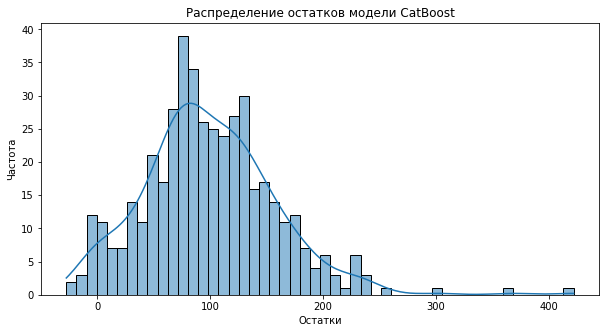

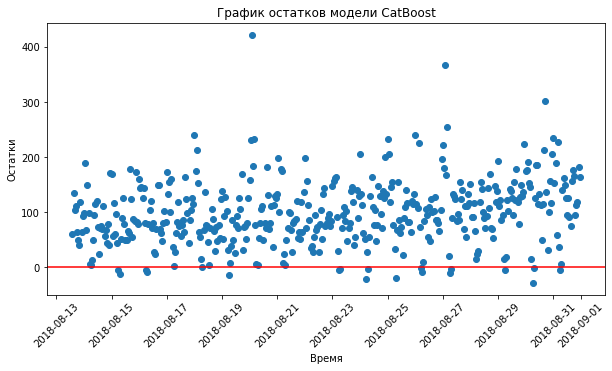

In [41]:
residuals = y_test - catboost_rmse  

# График остатков
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.title("Распределение остатков модели CatBoost")
plt.show()

# График остатков во времени
plt.figure(figsize=(10, 5))
plt.plot(residuals, marker='o', linestyle='')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Время")
plt.ylabel("Остатки")
plt.xticks(rotation=45)
plt.title("График остатков модели CatBoost")
plt.show()

* Остатки почти симметричны, но присутствует длинный правый хвост, что указывает на наличие нескольких больших положительных ошибок, когда модель сильно недооценивает реальное значение

* Остатки распределены примерно равномерно и хаотично вокруг 0, без явного тренда, однако есть несколько выбросов в положительную сторону

## Вывод

В рамках проекта была выполнена задача прогнозирования количества заказов такси в аэропортах на ближайший час. Работа включала в себя полный цикл обработки данных: от загрузки и анализа до построения модели и оценки её качества.

1. **Предварительная обработка данных** :
3. **Обучение моделей** 
4. **Оценка качества** модели проводилась с использованием метрики RMSE. Модель показала хорошую точность и стабильность на тестовой выборке, уложившись в заданный порог ошибки

Ключевые результаты и выводы:

1. Анализ остатков модели:

* Распределение остатков модели почти симметрично, однако наблюдается длинный правый хвост. Это говорит о том, что в ряде случаев модель значительно недооценивает реальное значение

Итог:

Разработанная модель успешно решает задачу прогнозирования нагрузки на такси в аэропортах, что может быть использовано для оптимизации количества водителей в часы пик. Это позволит улучшить качество обслуживания клиентов и снизить потери от неудовлетворённого спроса. Анализ важности признаков и остатков подтверждает, что модель учитывает ключевые временные закономерности, однако модель можно доработать